<a href="https://colab.research.google.com/github/tacinunesc/Unimed-DIO-Transfer-Learning/blob/main/Unimed_DIO_Projeto_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Transferência de aprendizado

Este tutorial o guiará pelo processo de uso do aprendizado de transferência para aprender um classificador de imagem preciso a partir de um número relativamente pequeno de amostras de treinamento. De um modo geral, a aprendizagem de transferência refere-se ao processo de alavancar o conhecimento aprendido em um modelo para o treinamento de outro modelo.

Mais especificamente, o processo envolve pegar uma rede neural existente que foi previamente treinada para um bom desempenho em um conjunto de dados maior e usá-la como base para um novo modelo que aproveita a precisão da rede anterior para uma nova tarefa. Este método tornou-se popular nos últimos anos para melhorar o desempenho de uma rede neural treinada em um pequeno conjunto de dados; a intuição é que o novo conjunto de dados pode ser muito pequeno para ser treinado para um bom desempenho por si só, mas sabemos que a maioria das redes neurais treinadas para aprender recursos de imagem geralmente aprendem recursos semelhantes de qualquer maneira, especialmente nas camadas iniciais, onde são mais genéricos (detectores de borda, bolhas, e assim por diante).

A aprendizagem por transferência foi amplamente possibilitada pelo código aberto de modelos de última geração; para os modelos de melhor desempenho em tarefas de classificação de imagens (como do ILSVRC), é prática comum agora não apenas publicar a arquitetura, mas também liberar os pesos treinados do modelo. Isso permite que amadores usem esses classificadores de imagem para aumentar o desempenho de seus próprios modelos específicos de tarefas.

#Extração de recursos x ajuste fino

Em um extremo, o aprendizado de transferência pode envolver pegar a rede pré-treinada e congelar os pesos e usar uma de suas camadas ocultas (geralmente a última) como um extrator de recursos, usando esses recursos como entrada para uma rede neural menor.

No outro extremo, começamos com a rede pré-treinada, mas permitimos que alguns dos pesos (geralmente a última camada ou as últimas camadas) sejam modificados. Outro nome para este procedimento é chamado de "ajuste fino" porque estamos ajustando levemente os pesos da rede pré-treinada para a nova tarefa. Normalmente treinamos essa rede com uma taxa de aprendizado menor, pois esperamos que os recursos já sejam relativamente bons e não precisem ser muito alterados.

Às vezes, fazemos algo intermediário: congelar apenas as camadas iniciais/genéricas, mas ajustar as camadas posteriores. Qual estratégia é a melhor depende do tamanho do seu conjunto de dados, do número de classes e do quanto ele se assemelha ao conjunto de dados no qual o modelo anterior foi treinado (e, portanto, se ele pode se beneficiar dos mesmos extratores de recursos aprendidos). Uma discussão mais detalhada de como criar estratégias pode ser encontrada em [1] [2].

#Procedimento

Neste guia, passaremos pelo processo de carregar um classificador de imagem de 1000 classes de última geração, VGG16, que venceu o desafio ImageNet em 2014, e usá-lo como um extrator de recursos fixos para treinar um classificador personalizado menor em nosso suas próprias imagens, embora com muito poucas alterações de código, você também pode tentar ajustar.

Primeiro vamos carregar o VGG16 e remover sua camada final, a camada de classificação softmax de 1000 classes específica para ImageNet, e substituí-la por uma nova camada de classificação para as classes sobre as quais estamos treinando. Em seguida, congelaremos todos os pesos na rede, exceto os novos que se conectam à nova camada de classificação, e treinaremos a nova camada de classificação sobre nosso novo conjunto de dados.

Também compararemos esse método com o treinamento de uma pequena rede neural do zero no novo conjunto de dados e, como veremos, melhorará drasticamente nossa precisão. Faremos essa parte primeiro.

Como nosso sujeito de teste, usaremos um conjunto de dados composto por cerca de 6.000 imagens pertencentes a 97 classes e treinaremos um classificador de imagens com cerca de 80% de precisão. Vale a pena notar que essa estratégia se adapta bem a conjuntos de imagens em que você pode ter apenas algumas centenas ou menos imagens. Seu desempenho será menor a partir de um pequeno número de amostras (dependendo das classes) como de costume, mas ainda impressionante considerando as restrições usuais.

In [1]:
%matplotlib inline
import os

#se estiver usando Theano com GPU
#os.environ["KERAS_BACKEND"] = "tensorflow"

import random
import numpy as np
import keras

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

from keras.preprocessing import image
from keras.applications.imagenet_utils import preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Model
import tensorflow_datasets as tfds

import tensorflow as tf

#Como obter um conjunto de dados

Como obter um conjunto de dados?
O primeiro passo será carregar nossos dados. Como nosso exemplo, usaremos o conjunto de dados CalTech-101, que contém cerca de 9.000 imagens rotuladas pertencentes a 101 categorias de objetos. No entanto, excluiremos 5 das categorias que tiverem mais imagens. Isso é para manter a distribuição de classes bastante equilibrada (em torno de 50-100) e restrita a um número menor de imagens, em torno de 6.000.

Para obter esse conjunto de dados, você pode executar o script de download download.sh na pasta de dados ou os seguintes comandos:

wget http://www.vision.caltech.edu/Image_Datasets/Caltech101/101_ObjectCategories.tar.gz
tar -xvzf 101_ObjectCategories.tar.gz

Se você deseja usar seu próprio conjunto de dados, ele deve ser organizado da mesma forma para 101_ObjectCategories com todas as imagens organizadas em subpastas, uma para cada classe. Nesse caso, a célula a seguir deve carregar seu conjunto de dados personalizado corretamente apenas substituindo root por sua pasta. Se você tiver uma estrutura alternativa, você só precisa ter certeza de carregar os dados da lista onde cada elemento é um dict onde x são os dados (um array numpy 1-d) e y é o rótulo (um inteiro). Use a função auxiliar get_image(path) para carregar a imagem corretamente no array e observe também que as imagens estão sendo redimensionadas para 224x224. Isso é necessário porque a entrada para VGG16 é uma imagem RGB de 224x224. Você não precisa redimensioná-los em seu disco rígido, pois isso está sendo feito no código abaixo.

Se você tiver 101_ObjectCategories em sua pasta de dados, a célula a seguir deverá carregar todos os dados.

In [2]:
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

BATCH_SIZE=1
IMG_SIZE = (160, 160)

68606236/68606236 [==============================] - 1s 0us/step


In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# FUNÇÃO GRADUADA: train_val_generators
def train_val_generators(TRAINING_DIR, VALIDATION_DIR):
  """
  Cria os geradores de dados de treinamento e validação
  
   Args:
     TRAINING_DIR (string): caminho do diretório que contém as imagens de treinamento
     VALIDATION_DIR (string): caminho do diretório que contém as imagens de teste/validação
    
   Devoluções:
     train_generator, validation_generator: tupla contendo os geradores
  """
  ### COMECE O CÓDIGO AQUI

  # Instanciar a classe ImageDataGenerator
  # Não se esqueça de normalizar os valores de pixel e definir argumentos para aumentar as imagens 
  train_datagen = ImageDataGenerator(rescale=1.0/255.)

  # Passe os argumentos apropriados para o método flow_from_directory
  train_generator = tf.keras.utils.image_dataset_from_directory(directory=TRAINING_DIR,
                                                      batch_size=BATCH_SIZE, 
                                                      #class_mode='binary',
                                                      image_size=IMG_SIZE)

  # Instancie a classe ImageDataGenerator (não se esqueça de definir o argumento rescale)
  # Lembre-se de que os dados de validação não devem ser aumentados
  validation_datagen = ImageDataGenerator(rescale=1.0/255.)

  # Passe os argumentos apropriados para o método flow_from_directory
  validation_generator = tf.keras.utils.image_dataset_from_directory(directory=VALIDATION_DIR,
                                                                batch_size=BATCH_SIZE, 
                                                                #class_mode='binary',
                                                                image_size=IMG_SIZE)
  ### FIM DO CÓDIGO AQUI
  return train_generator, validation_generator

Pré-processe os dados como antes, certificando-se de que sejam float32 e normalizados entre 0 e 1.

In [4]:
# Teste seus geradores
train_generator, validation_generator = train_val_generators(train_dir, validation_dir)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


In [5]:
print(train_generator.options)
print(train_generator.class_names)

class_names = train_generator.class_names
num_classes=len(class_names)

<bound method DatasetV2.options of <BatchDataset element_spec=(TensorSpec(shape=(None, 160, 160, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>>
['cats', 'dogs']


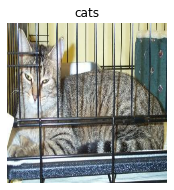

In [6]:
plt.figure(figsize=(10, 10))
for images, labels in train_generator.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Padronize os dados

Os valores do canal RGB estão na faixa [0, 255] . Isso não é ideal para uma rede neural; em geral, você deve procurar tornar seus valores de entrada pequenos.

Aqui, você padronizará os valores para estarem no intervalo [0, 1] usando tf.keras.layers.Rescaling :

In [7]:
IMG_SIZE = 224
resize_and_rescale = tf.keras.Sequential([
  tf.keras.layers.Resizing(IMG_SIZE, IMG_SIZE),
  tf.keras.layers.Rescaling(1./255)
])

In [8]:
def normalizatiton_resize(train_ds):
  normalized_ds = train_ds.map(lambda x, y: (resize_and_rescale(x), y))
  return normalized_ds

In [9]:
train_generator = normalizatiton_resize(train_generator)
image_batch, labels_batch = next(iter(train_generator))
first_image = image_batch[0]
# Observe que os valores de pixel agora estão em `[0,1]`.
print(np.min(first_image), np.max(first_image))
print(train_generator)

0.03001299 1.0
<MapDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [10]:
validation_generator = normalizatiton_resize(validation_generator)

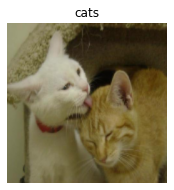

In [11]:
plt.figure(figsize=(10, 10))
for images, labels in validation_generator.take(1):
  for i in range(1):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow((images[i].numpy()*255).astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

#Primeiro treinando uma rede neural do zero

Antes de fazer o aprendizado de transferência, vamos primeiro construir uma rede neural do zero para fazer a classificação em nosso conjunto de dados. Isso nos dará uma linha de base para comparar com nossa rede aprendida por transferência mais tarde.

A rede que construiremos contém 4 camadas alternadas convolucional e de pool máximo, seguidas por um dropout após cada par conv/pooling. Após a última camada de pooling, anexaremos uma camada totalmente conectada com 256 neurônios, outra camada dropout e, finalmente, uma camada de classificação softmax para nossas classes.

Nossa função de perda será, como de costume, perda categórica de entropia cruzada, e nosso algoritmo de aprendizado será AdaDelta. Várias coisas sobre esta rede podem ser alteradas para obter melhor desempenho, talvez usar uma rede maior ou um otimizador diferente ajude, mas para os propósitos deste notebook, o objetivo é apenas obter uma compreensão de uma linha de base aproximada para fins de comparação e então não é necessário gastar muito tempo tentando otimizar esta rede.

Ao compilar a rede, vamos executar model.summary() para obter um instantâneo de suas camadas.

In [12]:
# construa a rede
model = Sequential()
print("Input dimensions: ",(224, 224,3))


model.add(Conv2D(32, (3, 3), input_shape=(224, 224, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256))
model.add(Activation('relu'))

model.add(Dropout(0.5))

model.add(Dense(num_classes*64))
model.add(Dense(2, activation='softmax'))


model.summary()

Input dimensions:  (224, 224, 3)
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 activation (Activation)     (None, 222, 222, 32)      0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 32)      9248      
                                                                 
 activation_1 (Activation)   (None, 109, 109, 32)      0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 32)       0         
 2D)                 

Criamos uma rede de tamanho médio com aproximadamente 1,2 milhão de pesos e vieses (os parâmetros). A maioria deles está levando para uma camada totalmente conectada pré-softmax "dense_5".

Agora podemos ir em frente e treinar nosso modelo para 100 épocas com um tamanho de lote de 128. Também registraremos seu histórico para que possamos plotar a perda ao longo do tempo mais tarde.

In [15]:
# compilar o modelo para usar a função de perda de entropia cruzada categórica e o otimizador adadelta
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_generator,
                    batch_size=32,
                    epochs=10,
                    validation_data=validation_generator)

Epoch 1/10
2000/2000 [==============================] - 213s 106ms/step - loss: 0.6939 - accuracy: 0.4800 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/10
2000/2000 [==============================] - 197s 98ms/step - loss: 0.6945 - accuracy: 0.4970 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 3/10
2000/2000 [==============================] - 201s 100ms/step - loss: 0.6940 - accuracy: 0.4900 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 4/10
2000/2000 [==============================] - 196s 98ms/step - loss: 0.6945 - accuracy: 0.4875 - val_loss: 0.6933 - val_accuracy: 0.5000
Epoch 5/10
2000/2000 [==============================] - 198s 99ms/step - loss: 0.6942 - accuracy: 0.4985 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 6/10
2000/2000 [==============================] - 199s 100ms/step - loss: 0.6942 - accuracy: 0.4850 - val_loss: 0.6934 - val_accuracy: 0.5000
Epoch 7/10
2000/2000 [==============================] - 199s 99ms/step - loss: 0.6941 - accuracy: 0.4915 - val_loss

Vamos plotar a perda de validação e a precisão da validação ao longo do tempo.

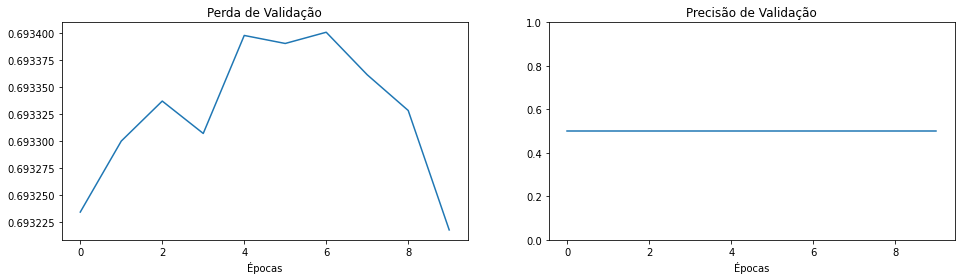

In [16]:
fig = plt.figure(figsize=(16,4))
ax = fig.add_subplot(121)
ax.plot(history.history["val_loss"])
ax.set_title("Perda de Validação")
ax.set_xlabel("Épocas")

ax2 = fig.add_subplot(122)
ax2.plot(history.history["val_accuracy"])
ax2.set_title("Precisão de Validação")
ax2.set_xlabel("Épocas")
ax2.set_ylim(0, 1)

plt.show()

Observe que a perda de validação começa a aumentar após cerca de 16 épocas, embora a precisão da validação permaneça aproximadamente entre 40% e 50%. Isso sugere que nosso modelo começa a se ajustar por volta dessa época, e o melhor desempenho teria sido alcançado se tivéssemos parado cedo nessa época. No entanto, nossa precisão provavelmente não teria sido superior a 50%, e provavelmente inferior.

Também podemos obter uma avaliação final executando nosso modelo no conjunto de treinamento. Fazendo isso, obtemos os seguintes resultados:

In [17]:
loss, accuracy = model.evaluate(validation_generator, verbose=0)
print('Test loss:', loss)
print('Test accuracy:', accuracy)

Test loss: 0.693217396736145
Test accuracy: 0.5


Por fim, vemos que atingimos uma precisão (top-1) de cerca de 49%. Isso não é tão ruim para 6000 imagens, considerando que se usássemos uma estratégia ingênua de fazer suposições aleatórias, teríamos obtido apenas cerca de 1% de precisão.

#Transfira o aprendizado começando com a rede existente

Agora podemos passar para a estratégia principal para treinar um classificador de imagens em nosso pequeno conjunto de dados: começando com uma rede maior e já treinada.

Para começar, vamos carregar o VGG16 do keras, que foi treinado no ImageNet e os pesos salvos online. Se esta for sua primeira vez carregando o VGG16, você precisará esperar um pouco para que os pesos sejam baixados da web. Uma vez que a rede é carregada, podemos inspecionar novamente as camadas com o método summary().

In [18]:
vgg = keras.applications.vgg16.VGG16(weights='imagenet', include_top=True)
vgg.summary()

553467096/553467096 [==============================] - 4s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                            

Observe que o VGG16 é muito maior que a rede que construímos anteriormente. Ele contém 13 camadas convolucionais e duas camadas totalmente conectadas no final, e tem mais de 138 milhões de parâmetros, cerca de 100 vezes mais parâmetros do que a rede que fizemos acima. Como nossa primeira rede, a maioria dos parâmetros é armazenada nas conexões que levam à primeira camada totalmente conectada.

O VGG16 foi feito para resolver o ImageNet e atinge uma taxa de erro top 5 de 8,8%, o que significa que 91,2% das amostras de teste foram classificadas corretamente dentro das 5 principais previsões para cada imagem. A precisão top 1 - equivalente à métrica de precisão que estamos usando (que a previsão principal está correta) - é de 73%. Isso é especialmente impressionante, pois não há apenas 97, mas 1.000 classes, o que significa que suposições aleatórias nos dariam apenas 0,1% de precisão.

Para usar essa rede para nossa tarefa, "removemos" a camada de classificação final, a camada softmax de 1000 neurônios no final, que corresponde ao ImageNet, e a substituímos por uma nova camada softmax para nosso conjunto de dados, que contém 97 neurônios no caso do conjunto de dados 101_ObjectCategories.

Em termos de implementação, é mais fácil simplesmente criar uma cópia do VGG de sua camada de entrada até a penúltima camada e trabalhar com isso, em vez de modificar o objeto VGG diretamente. Então, tecnicamente, nunca "removemos" nada, apenas contornamos/ignoramos. Isso pode ser feito da seguinte maneira, usando a classe keras Model para inicializar um novo modelo cuja camada de entrada é a mesma que VGG, mas cuja camada de saída é nossa nova camada softmax, chamada new_classification_layer. Nota: embora pareça que estamos duplicando essa grande rede, internamente o Keras está apenas copiando todas as camadas por referência e, portanto, não precisamos nos preocupar em sobrecarregar a memória.

In [19]:
# faça uma referência à camada de entrada do VGG
inp = vgg.input

# faça uma nova camada softmax com neurônios num_classes

mider=Dense(num_classes*128,activation='relu')(vgg.layers[-2].output)
new_classification_layer = Dense(num_classes, activation='softmax')(mider)

# conecte nossa nova camada à penúltima camada no VGG e faça uma referência a ela
out = new_classification_layer

# crie uma nova rede entre entrada e saída
model_new = Model(inp, out)

Vamos treinar novamente essa rede, model_new no novo conjunto de dados e rótulos. Mas primeiro, precisamos congelar os pesos e desvios em todas as camadas da rede, exceto nossa nova no final, com a expectativa de que os recursos aprendidos no VGG ainda sejam bastante relevantes para a nova tarefa de classificação de imagens. Não é o ideal, mas provavelmente melhor do que podemos treinar em nosso conjunto de dados limitado.

Ao definir o sinalizador treinável em cada camada como false (exceto nossa nova camada de classificação), garantimos que todos os pesos e desvios nessas camadas permaneçam fixos e simplesmente treinamos os pesos em uma camada no final. Em alguns casos, é desejável não congelar todas as camadas de pré-classificação. Se o seu conjunto de dados tiver amostras suficientes e não se assemelhar muito ao ImageNet, pode ser vantajoso ajustar algumas das camadas VGG junto com o novo classificador, ou possivelmente até mesmo todas elas. Para fazer isso, você pode alterar o código abaixo para tornar mais das camadas treináveis.

No caso do CalTech-101, faremos apenas a extração de recursos, temendo que o ajuste fino demais com esse conjunto de dados possa ser excessivo. Mas talvez estejamos errados? Um bom exercício seria experimentar ambos e comparar os resultados.

Então vamos em frente e congelamos as camadas, e compilamos o novo modelo com exatamente o mesmo otimizador e função de perda que em nossa primeira rede, para uma comparação justa. Em seguida, executamos o resumo novamente para observar a arquitetura da rede.

In [20]:
# torne todas as camadas não treináveis congelando pesos (exceto a última camada)
for l, layer in enumerate(model_new.layers[:-1]):
    layer.trainable = False

# garante que a última camada seja treinável/não congelada
for l, layer in enumerate(model_new.layers[-1:]):
    layer.trainable = True

model_new.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model_new.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Observando o resumo, vemos que a rede é idêntica ao modelo VGG que instanciamos anteriormente, exceto que a última camada, anteriormente um softmax de 1.000 neurônios, foi substituída por um novo softmax de 97 neurônios. Além disso, ainda temos cerca de 134 milhões de pesos, mas agora a grande maioria deles são "parâmetros não treináveis" porque congelamos as camadas em que estão contidos. Agora temos apenas 397.000 parâmetros treináveis, o que na verdade é apenas um quarto dos número de parâmetros necessários para treinar o primeiro modelo.

